# Goal: Given a head to head win probability for player 1, what's the probability that player 1 beats N others?

Seems straightforward at first. Say player 1 has a 50% win rate against one other player ($W_1 = 0.5, N = 1$). Then if there are 2 other players($W_1 = 0.5, N = 2$), the probability that player 1 beats them both is the probability that player 1 beats player 2 times the probability that player 1 beats player 3:

$$ W_2 = W_1 ^ N $$

$$ W_2 = 0.5 ^ 2 = 0.25 $$

On the other hand, if there are 3 players and they all have an equal chance of winning, then the probability that player 1 is the winner should be the same as the odds that player 2 is the winner, and the same probability that player 3 is the winner, so:

$$ W_2 = 1/N\ given\ W_1 = 0.5 $$

or maybe more generally something like:

$$ W_2 = 1/N * (2 * W_1) for N >= 1$$


In [1]:
# this gets us W_1 for some given set of cards known to player 1
from texas_hold_em_utils.hands import HandOfFive
from texas_hold_em_utils.deck import Deck


def rank_hand(hand, community_cards):
    """
    Ranks a hand of two cards and 3-5 five community cards relative to all other possible hands, based only on known cards
    :param hand: a list of 2 cards (Card objects)
    :param community_cards: a list of 3-5 cards (Card objects)
    :return: a tuple of the number of wins, losses, and ties for the given hand
    """
    player_hand = HandOfFive(hand, community_cards)
    deck1 = Deck()
    deck2 = Deck()
    wins = 0
    losses = 0
    ties = 0
    for card1 in deck1.cards:
        if card1 not in hand + community_cards:
            for card2 in deck2.cards:
                if card2 not in hand + community_cards and card2 != card1:
                    other_hand = HandOfFive([card1, card2], community_cards)
                    if player_hand > other_hand:
                        wins += 1
                    elif player_hand < other_hand:
                        losses += 1
                    else:
                        ties += 1
    return wins, losses, ties

In [3]:
# W_2 version
def rank_hand_against_2_players(hand, community_cards):
    player_hand = HandOfFive(hand, community_cards)
    deck1 = Deck()
    deck2 = Deck()
    deck3 = Deck()
    deck4 = Deck()
    wins = 0
    losses = 0
    ties = 0
    for card1 in deck1.cards:
        if card1 not in hand + community_cards:
            for card2 in deck2.cards:
                if card2 not in hand + community_cards and card2 != card1:
                    other_hand_1 = HandOfFive([card1, card2], community_cards)
                    for card3 in deck3.cards:
                        if card3 not in hand + community_cards and card3 != card1 and card3 != card2:
                            for card4 in deck4.cards:
                                other_hand_2 = HandOfFive([card3, card4], community_cards)
                                if player_hand > other_hand_1 and player_hand > other_hand_2:
                                    wins += 1
                                elif player_hand < other_hand_1 or player_hand < other_hand_2:
                                    losses += 1
                                else:
                                    ties += 1
    return wins, losses, ties

In [4]:
import pandas as pd

rnd_deck = Deck()
rnd_deck.shuffle()

hand = []
hand.append(rnd_deck.draw())
hand.append(rnd_deck.draw())
community_cards = []
community_cards.append(rnd_deck.draw())
community_cards.append(rnd_deck.draw())
community_cards.append(rnd_deck.draw())
community_cards.append(rnd_deck.draw())
community_cards.append(rnd_deck.draw())

print(hand, community_cards)
print(rank_hand(hand, community_cards))
print(rank_hand_against_2_players(hand, community_cards))

[<texas_hold_em_utils.card.Card object at 0x000001C948793110>, <texas_hold_em_utils.card.Card object at 0x000001C948790510>] [<texas_hold_em_utils.card.Card object at 0x000001C948793010>, <texas_hold_em_utils.card.Card object at 0x000001C9485DADD0>, <texas_hold_em_utils.card.Card object at 0x000001C94875FFD0>, <texas_hold_em_utils.card.Card object at 0x000001C9485DBD10>, <texas_hold_em_utils.card.Card object at 0x000001C94875D050>]
(856, 1112, 12)
(744928, 3655376, 26976)


In [7]:
df = pd.DataFrame(columns=['wins_1', 'losses_1', 'ties_1', 'wins_2', 'losses_2', 'ties_2'])

for i in range(250):
    rnd_deck = Deck()
    rnd_deck.shuffle()

    hand = []
    hand.append(rnd_deck.draw())
    hand.append(rnd_deck.draw())
    community_cards = []
    community_cards.append(rnd_deck.draw())
    community_cards.append(rnd_deck.draw())
    community_cards.append(rnd_deck.draw())
    community_cards.append(rnd_deck.draw())
    community_cards.append(rnd_deck.draw())
    
    wins_1, losses_1, ties_1 = rank_hand(hand, community_cards)
    wins_2, losses_2, ties_2 = rank_hand_against_2_players(hand, community_cards)
    
    df = pd.concat([df, pd.DataFrame({'wins_1': [wins_1], 'losses_1': [losses_1], 'ties_1': [ties_1], 'wins_2': [wins_2], 'losses_2': [losses_2], 'ties_2': [ties_2]})])

In [8]:
df.to_csv('data/win_rate_vs_n_players.csv', index=False)

In [10]:
df['win_rate_1'] = ((df['wins_1'] * 2) + df['ties_1']) / ((df['wins_1'] + df['losses_1'] + df['ties_1']) *2)

In [11]:
df['win_rate_2'] = ((df['wins_2'] * 2) + df['ties_2']) / ((df['wins_2'] + df['losses_2'] + df['ties_2']) *2)

<Axes: xlabel='win_rate_1', ylabel='win_rate_2'>

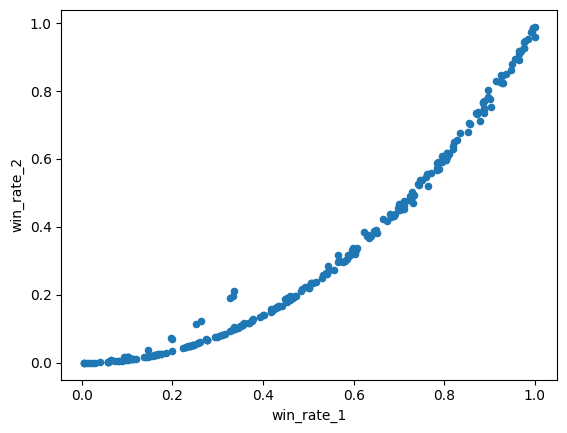

In [12]:
df.plot(x='win_rate_1', y='win_rate_2', kind='scatter')

In [13]:
df['win_rate_1'].corr(df['win_rate_2'])

0.9618075901027451

In [14]:
df['win_rate_1_sq'] = df['win_rate_1'] * df['win_rate_1']
df['win_rate_1_sq'].corr(df['win_rate_2'])

0.9982443433911925

In [15]:
df.head(40)

,wins_1,losses_1,ties_1,wins_2,losses_2,ties_2,win_rate_1,win_rate_2,win_rate_1_sq
0,1874,100,6,3801632,584416,41232,0.94798,0.86334,0.898666
0,1818,116,46,3498000,631608,297672,0.929798,0.823719,0.864524
0,1340,628,12,1916224,2468048,43008,0.679798,0.437679,0.462125
0,1666,142,172,3045312,685270,696698,0.884848,0.766534,0.782957
0,0,984,996,0,3413538,1013742,0.251515,0.114488,0.06326
0,482,1480,18,226648,4181316,19316,0.24798,0.053375,0.061494
0,1436,532,12,2201320,2179376,46584,0.728283,0.502478,0.530396
0,1332,496,152,1786656,2104112,536512,0.711111,0.464148,0.505679
0,976,1002,2,982784,3435168,9328,0.493434,0.223037,0.243477
0,856,1112,12,729152,3671312,26816,0.435354,0.167724,0.189533


<Axes: >

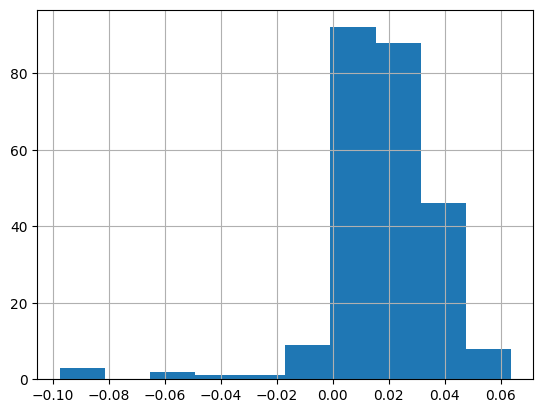

In [16]:
df['error'] = df['win_rate_1_sq'] - df['win_rate_2']
df['error'].hist()

# Conclusion

$W_N$ is approximated by $W_1^N$ 